<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/PyTorch%E6%9C%AC3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.8 推論の実施
本ファイルでは、学習させたPSPNetでセマンティックセグメンテーションを行います。

#学習目標
* セマンティックセグメンテーションの推論を実装できるようになる


[写経元](https://github.com/YutaroOgawa/pytorch_advanced/blob/master/3_semantic_segmentation/3-8_PSPNet_inference.ipynb)

In [0]:

import google.colab
import googleapiclient.discovery
import googleapiclient.http
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [24]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 441, done.
remote: Total 441 (delta 0), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (441/441), 14.62 MiB | 30.56 MiB/s, done.
Resolving deltas: 100% (231/231), done.


In [25]:
%cd pytorch_advanced/
%cd 3_semantic_segmentation/

/content/pytorch_advanced/3_semantic_segmentation/pytorch_advanced
/content/pytorch_advanced/3_semantic_segmentation/pytorch_advanced/3_semantic_segmentation


In [30]:
def gdrive_dl(filename):
  upload_filename = filename

  file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

  # ファイル ID を取得します。
  file_id = None
  for file in file_list:
    if file.get('name') == upload_filename:
      file_id = file.get('id')
      break

  if file_id is None:
    # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
    print(upload_filename + ' が見つかりません.')
  else:
    # colab 環境へファイルをアップロードします。
    with open(upload_filename, 'wb') as f:
      request = drive_service.files().get_media(fileId=file_id)
      media = googleapiclient.http.MediaIoBaseDownload(f, request)

      done = False
      while not done:
        progress_status, done = media.next_chunk()
        print(100*progress_status.progress(), end="")
        print("%完了")

    print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')
    
gdrive_dl("pspnet50_30.pth")

53.32253063780266%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [0]:
import os
import urllib.request
import zipfile
import tarfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [0]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [0]:
'''
#https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I
url = "https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I"
target_path = os.path.join(weights_dir, "pspnet50_30.pth") 

if not os.path.exists(target_path):
  urllib.request.urlretrieve(url, target_path)
'''

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

# ファイルパスリストを用意

In [0]:
from utils.dataloader import make_datapath_list, DataTransform


# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する

# ネットワークを用意

In [32]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("pspnet50_30.pth",map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


# 推論実行

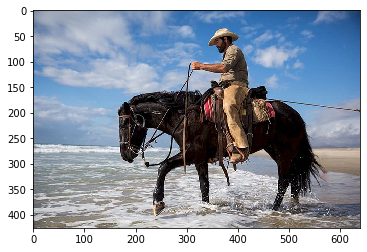

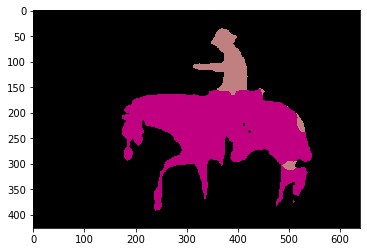

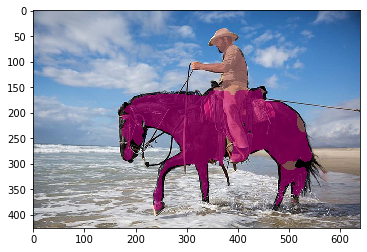

In [33]:
# 1. 元画像の表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)


# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])


# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()